In [2]:
def get_sd_reb_start(subject, exp):
    """Gets the SD start time and the rebound start time for a given subject and experiment."""
    
    # load some basic information, and the hypnogram
    h = acr.io.load_hypno_full_exp(subject, exp, update=False)
    rec_times = acr.info_pipeline.subject_info_section(subject, 'rec_times')

    # load some temporal information about the rebound, baseline, sd, etc. 
    stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
    reb_start = h.hts(stim_end-pd.Timedelta('15min'), stim_end+pd.Timedelta('1h')).st('NREM').iloc[0].start_time
    if reb_start < stim_end:
        stim_end_hypno = h.loc[(h.start_time<stim_end)&(h.end_time>stim_end)] # if stim time is in the middle of a nrem bout, then it can be the start of the rebound
        if stim_end_hypno.state.values[0] == 'NREM':
            reb_start = stim_end
        else:
            raise ValueError('Rebound start time is before stim end time, need to inspect')

    assert reb_start >= stim_end, 'Rebound start time is before stim end time'

    bl_start_actual = rec_times[f'{exp}-bl']["start"]
    bl_day = bl_start_actual.split("T")[0]
    bl_start = pd.Timestamp(bl_day + "T09:00:00")

    if f'{exp}-sd' in rec_times.keys():
        sd_rec = f'{exp}-sd'
        sd_end = pd.Timestamp(rec_times[sd_rec]['end'])
    else:
        sd_rec = exp
        sd_end = stim_start
    sd_start_actual = pd.Timestamp(rec_times[sd_rec]['start'])
    sd_day = rec_times[sd_rec]['start'].split("T")[0]
    sd_start = pd.Timestamp(sd_day + "T09:00:00")
    return sd_start, reb_start

In [3]:
def bp_plot_pandas(bp, ax, hyp=None, color=None):
    if color == None:
        ax.plot(bp['datetime'], bp['delta'])
    else:
        ax.plot(bp['datetime'], bp['delta'], color=color)
    if hyp is not None:
        kde.plot.main.shade_hypno_for_me(hyp, ax)
    #add_light_schedule(bp.light_schedule(), ax)
    return ax

In [1]:
#-------------------------- Standard Imports --------------------------#
%reload_ext autoreload
%autoreload 2
import kdephys as kde
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import acr
import os
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots.mplstyle')

# ---------------------------- EXTRAS --------------------------------#
from acr.utils import swi_subs_exps, sub_probe_locations, sub_exp_types

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# SWISIN

In [4]:
subject = 'ACR_20'
exp = 'swisin'
stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
recordings = acr.info_pipeline.get_exp_recs(subject, exp)
stores = ['NNXo', 'NNXr']
REL_STATE = 'NREM'
bp = acr.io.load_concat_bandpower(subject, recordings, stores, hypno=True, update_hyp=False);
bp_rel = kde.xr.utils.rel_by_store(bp, state=REL_STATE, t1=None, t2=None);
h = acr.io.load_hypno_full_exp(subject, exp, update=False)

/home/kdriessen/miniconda3/envs/acr_bg/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr_bg/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr_bg/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr_bg/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr_bg/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdri

In [5]:
sd_start, reb_start = get_sd_reb_start(subject, exp)
buffer_pre = '4.5h'
buffer_post = '3h'
t1 = stim_start - pd.Timedelta(buffer_pre)
t2 = stim_end + pd.Timedelta(buffer_post)

In [6]:
o = bp_rel.sel(store='NNXo').delta.sel(channel=10).ts(t1, t2)
o = o.to_dataframe().reset_index()

In [7]:
r = bp_rel.sel(store='NNXr').delta.sel(channel=10).ts(t1, t2)
r = r.to_dataframe().reset_index()

In [8]:
import random
o.loc[(o.delta >1.0) & (o.datetime < reb_start), 'delta'] = random.uniform(0.3, 1.0)
r.loc[(r.delta >1.0) & (r.datetime < reb_start), 'delta'] = random.uniform(0.3, 1.0)

/tmp/ipykernel_712074/970852237.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.30194532616272224' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  o.loc[(o.delta >1.0) & (o.datetime < reb_start), 'delta'] = random.uniform(0.3, 1.0)
/tmp/ipykernel_712074/970852237.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7019152424893287' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  r.loc[(r.delta >1.0) & (r.datetime < reb_start), 'delta'] = random.uniform(0.3, 1.0)


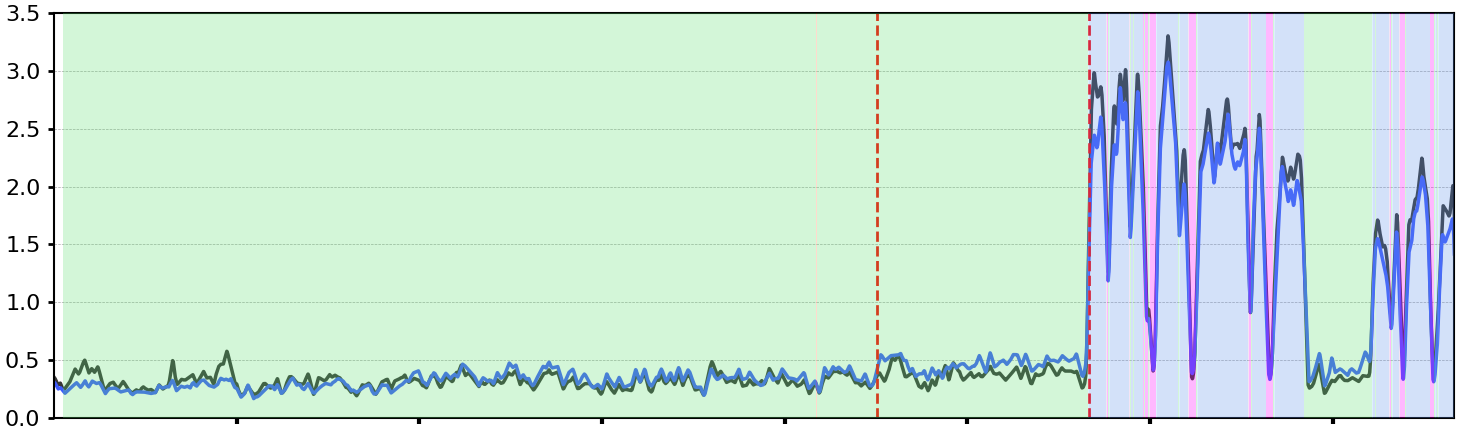

In [9]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_continuous.mplstyle')
buffer_pre = '4.5h'
buffer_post = '2h'
t1 = stim_start - pd.Timedelta(buffer_pre)
t2 = stim_end + pd.Timedelta(buffer_post)

f, ax = plt.subplots(1, 1, figsize=(35, 10), sharex=True)
ax.set_ylim(0, 3.5);

# plot delta and gamma power
bp_plot_pandas(r.sm(col='delta', sigma=16), ax, h)
bp_plot_pandas(o.sm(col='delta', sigma=16), ax, h)
ax.set_xlim(t1, t2)
# plot relative firing rate
#ax[2] = acr.pl_units.plot_fr_by_probe(df_rel.ts(t1, t2), h, ax=ax[2], color=True)
#add the stimulation start and end times
ax.axvline(stim_start, color='red', linestyle='--', linewidth=4)
ax.axvline(stim_end, color='red', linestyle='--', linewidth=4)
ax.set_xticklabels('')
#kde.plot.main._title(ax, subject, exp, f'Delta Bandpower Relative to BL-NREM Mean (channel-{channel})');
f.savefig(f'./plots/{subject}_{exp}_delta_bp_continuous.png', dpi=300, bbox_inches='tight')

# SWI

In [21]:
subject = 'ACR_18'
exp = 'swi'
stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
recordings = acr.info_pipeline.get_exp_recs(subject, exp)
stores = ['NNXo', 'NNXr']
REL_STATE = 'NREM'
bp = acr.io.load_concat_bandpower(subject, recordings, stores, hypno=True, update_hyp=False);
bp_rel = kde.xr.utils.rel_by_store(bp, state=REL_STATE, t1=None, t2=None);
h = acr.io.load_hypno_full_exp(subject, exp, update=False)

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/home/kdriessen/miniconda

In [22]:
sd_start, reb_start = get_sd_reb_start(subject, exp)
buffer_pre = '4.5h'
buffer_post = '3h'
t1 = stim_start - pd.Timedelta(buffer_pre)
t2 = stim_end + pd.Timedelta(buffer_post)

In [23]:
o = bp_rel.sel(store='NNXo').delta.sel(channel=14).ts(t1, t2)
o = o.to_dataframe().reset_index()

In [24]:
r = bp_rel.sel(store='NNXr').delta.sel(channel=14).ts(t1, t2)
r = r.to_dataframe().reset_index()

In [25]:
import random
o.loc[(o.delta >1.0) & (o.datetime < stim_start), 'delta'] = random.uniform(0.3, 1.0)
r.loc[(r.delta >1.0) & (r.datetime < stim_start), 'delta'] = random.uniform(0.3, 1.0)

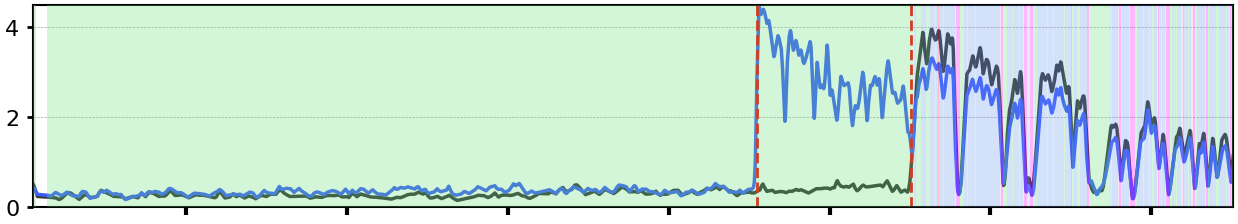

In [26]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_continuous.mplstyle')
buffer_pre = '4.5h'
buffer_post = '2h'
t1 = stim_start - pd.Timedelta(buffer_pre)
t2 = stim_end + pd.Timedelta(buffer_post)

f, ax = plt.subplots(1, 1, figsize=(30, 5), sharex=True)
ax.set_ylim(0, 4.5);

# plot delta and gamma power
bp_plot_pandas(r.sm(col='delta', sigma=16), ax, h)
bp_plot_pandas(o.sm(col='delta', sigma=16), ax, h)
ax.set_xlim(t1, t2)
# plot relative firing rate
#ax[2] = acr.pl_units.plot_fr_by_probe(df_rel.ts(t1, t2), h, ax=ax[2], color=True)
#add the stimulation start and end times
ax.axvline(stim_start, color='red', linestyle='--', linewidth=4)
ax.axvline(stim_end, color='red', linestyle='--', linewidth=4)
ax.set_xticklabels('')
#kde.plot.main._title(ax, subject, exp, f'Delta Bandpower Relative to BL-NREM Mean (channel-{channel})');
f.savefig(f'./plots/{subject}_{exp}_delta_bp_continuous.png', dpi=300, bbox_inches='tight')

# SWI - MARTINOTTI

In [27]:
subject = 'ACR_25'
exp = 'swi'
stim_start, stim_end = acr.stim.stim_bookends(subject, exp)
recordings = acr.info_pipeline.get_exp_recs(subject, exp)
stores = ['NNXo', 'NNXr']
REL_STATE = 'NREM'
bp = acr.io.load_concat_bandpower(subject, recordings, stores, hypno=True, update_hyp=False);
bp_rel = kde.xr.utils.rel_by_store(bp, state=REL_STATE, t1=None, t2=None);
h = acr.io.load_hypno_full_exp(subject, exp, update=False)

/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


Channel 10 not in NNXo for ACR_25 swi


/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


Channel 10 not in NNXo for ACR_25 swi


/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


Channel 7 not in NNXr for ACR_25 swi
Channel 13 not in NNXr for ACR_25 swi


/home/kdriessen/miniconda3/envs/acr/lib/python3.11/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


Channel 7 not in NNXr for ACR_25 swi
Channel 13 not in NNXr for ACR_25 swi


In [28]:
sd_start, reb_start = get_sd_reb_start(subject, exp)
buffer_pre = '4.5h'
buffer_post = '3h'
t1 = stim_start - pd.Timedelta(buffer_pre)
t2 = stim_end + pd.Timedelta(buffer_post)

In [29]:
o = bp_rel.sel(store='NNXo').delta.sel(channel=5).ts(t1, t2)
o = o.to_dataframe().reset_index()

In [30]:
r = bp_rel.sel(store='NNXr').delta.sel(channel=5).ts(t1, t2)
r = r.to_dataframe().reset_index()

In [31]:
import random
o.loc[(o.delta >1.0) & (o.datetime < stim_start), 'delta'] = random.uniform(0.3, 1.0)
r.loc[(r.delta >1.0) & (r.datetime < stim_start), 'delta'] = random.uniform(0.3, 1.0)

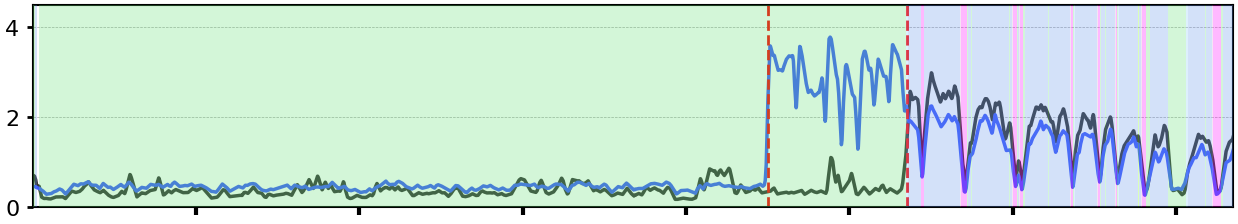

In [32]:
plt.style.use('fast')
plt.style.use('/home/kdriessen/gh_master/kdephys/kdephys/plot/acr_plots_continuous.mplstyle')
buffer_pre = '4.5h'
buffer_post = '2h'
t1 = stim_start - pd.Timedelta(buffer_pre)
t2 = stim_end + pd.Timedelta(buffer_post)

f, ax = plt.subplots(1, 1, figsize=(30, 5), sharex=True)
ax.set_ylim(0, 4.5);

# plot delta and gamma power
bp_plot_pandas(r.sm(col='delta', sigma=16), ax, h)
bp_plot_pandas(o.sm(col='delta', sigma=16), ax, h)
ax.set_xlim(t1, t2)
# plot relative firing rate
#ax[2] = acr.pl_units.plot_fr_by_probe(df_rel.ts(t1, t2), h, ax=ax[2], color=True)
#add the stimulation start and end times
ax.axvline(stim_start, color='red', linestyle='--', linewidth=4)
ax.axvline(stim_end, color='red', linestyle='--', linewidth=4)
ax.set_xticklabels('')
#kde.plot.main._title(ax, subject, exp, f'Delta Bandpower Relative to BL-NREM Mean (channel-{channel})');
f.savefig(f'./plots/{subject}_{exp}_delta_bp_continuous.png', dpi=300, bbox_inches='tight')

# MISC

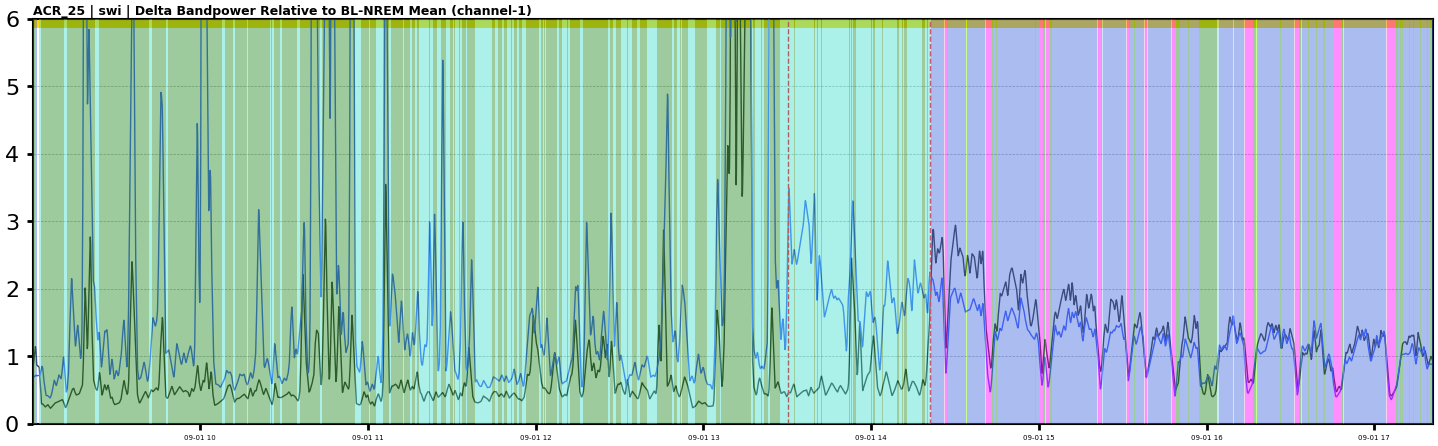

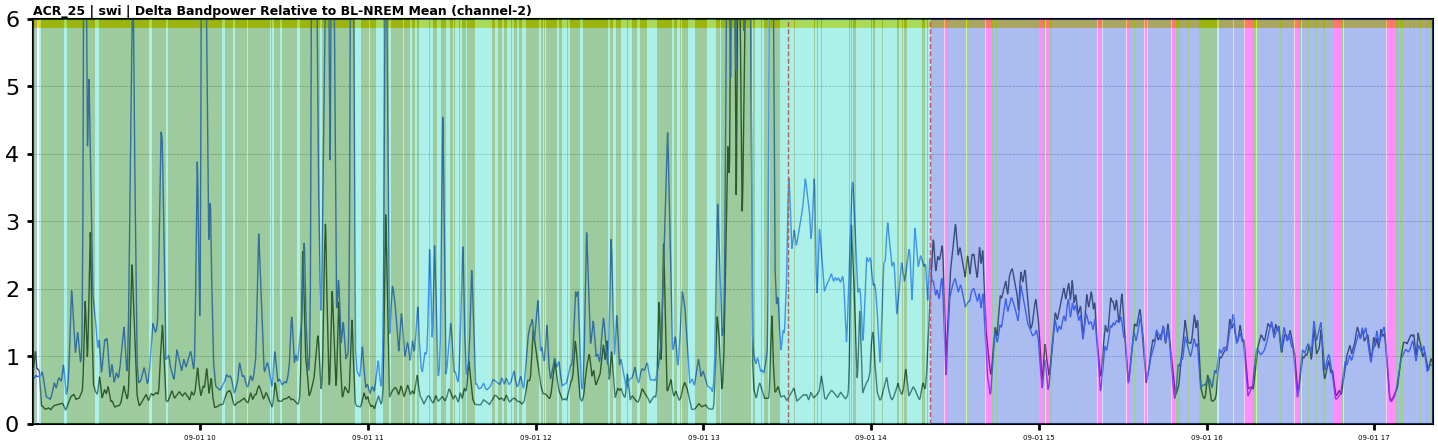

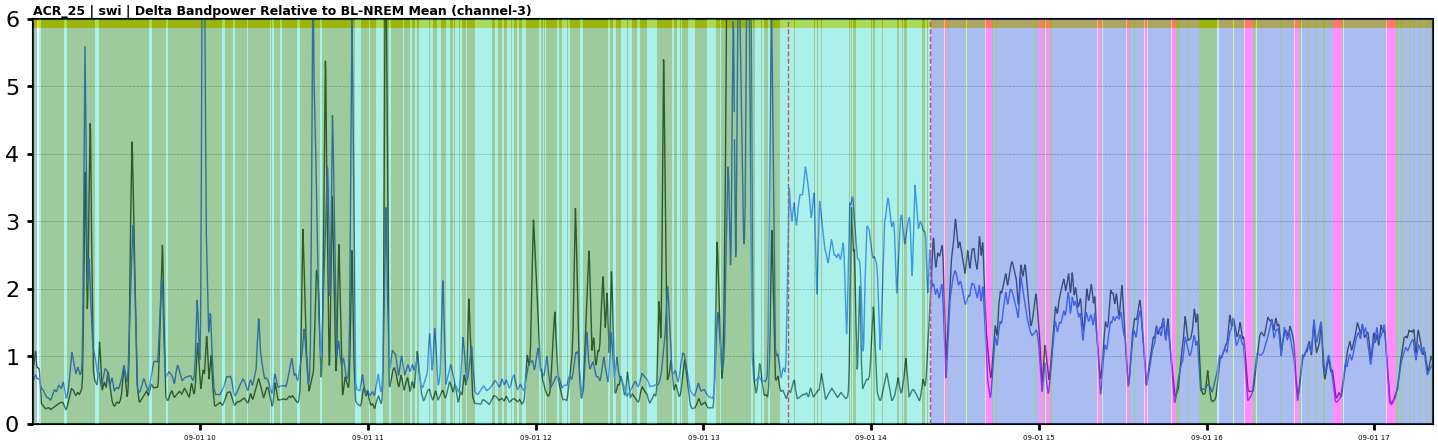

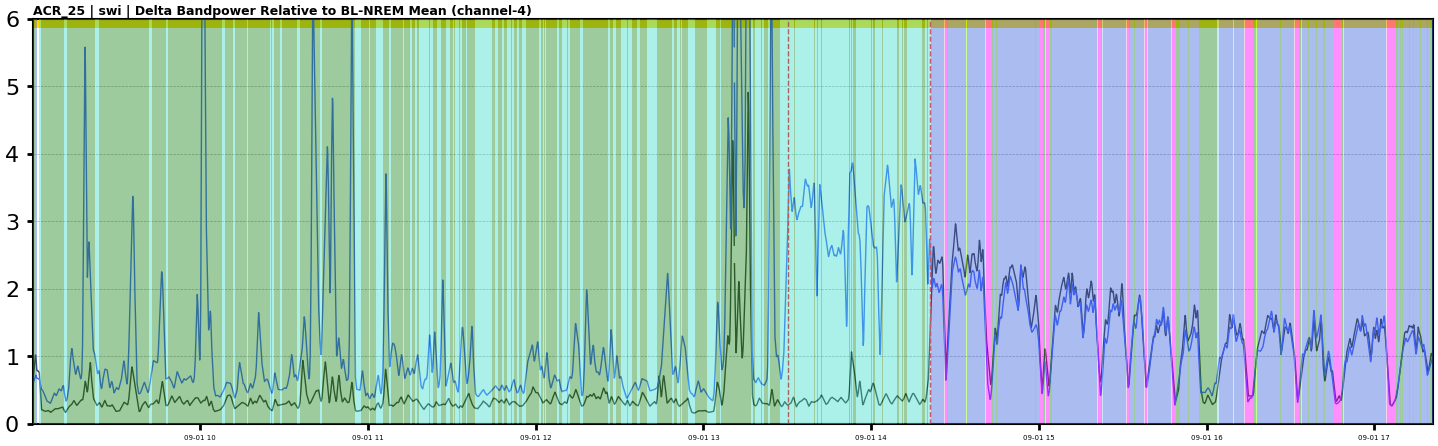

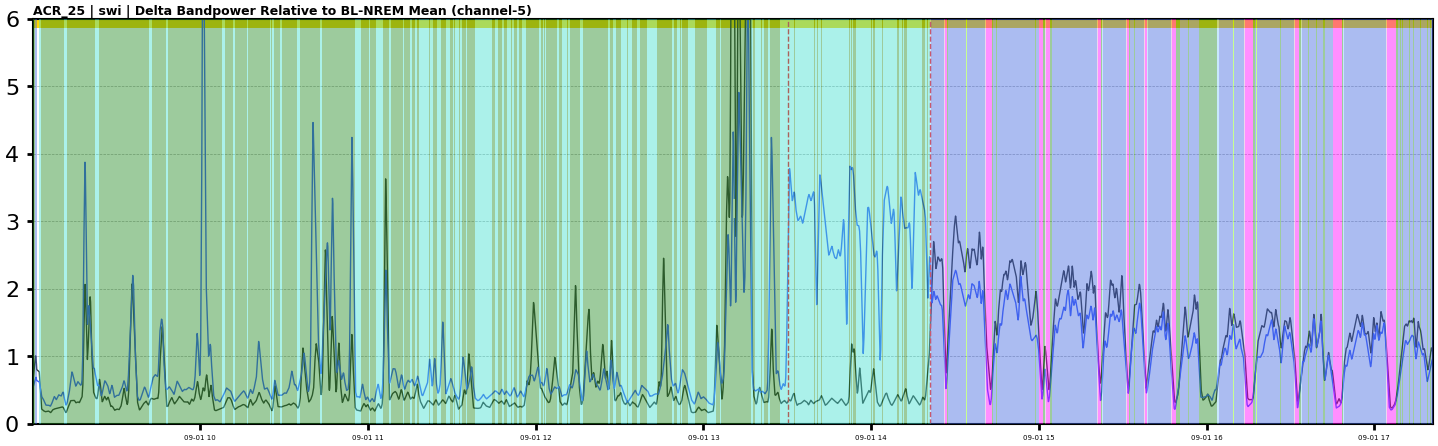

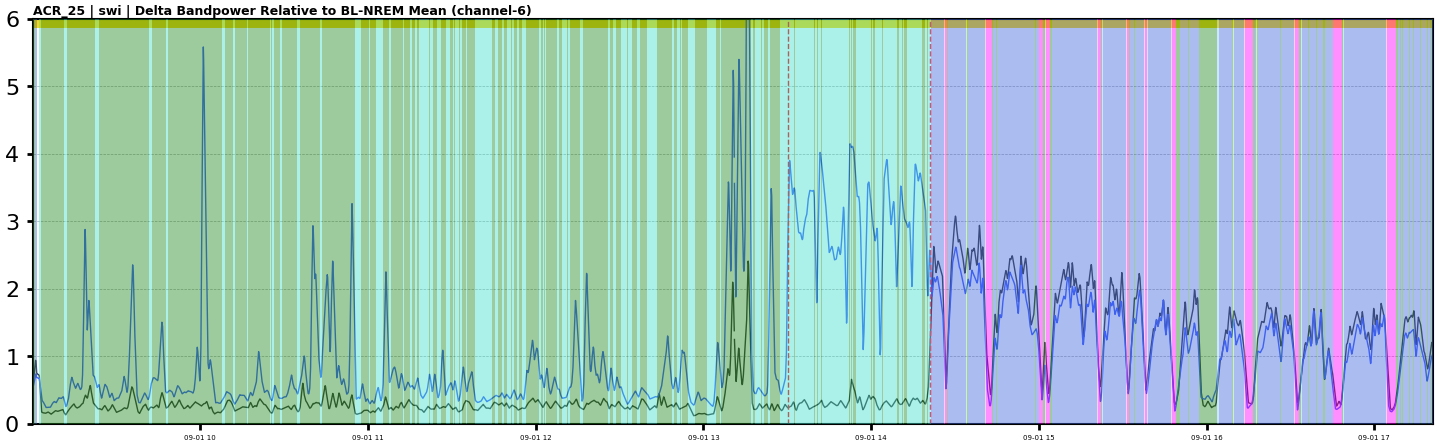

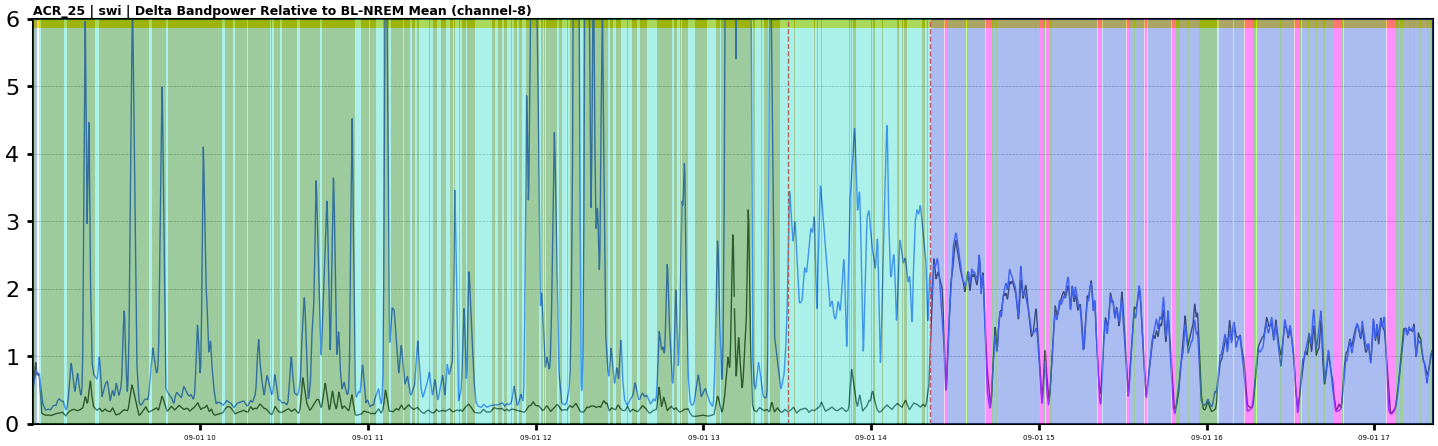

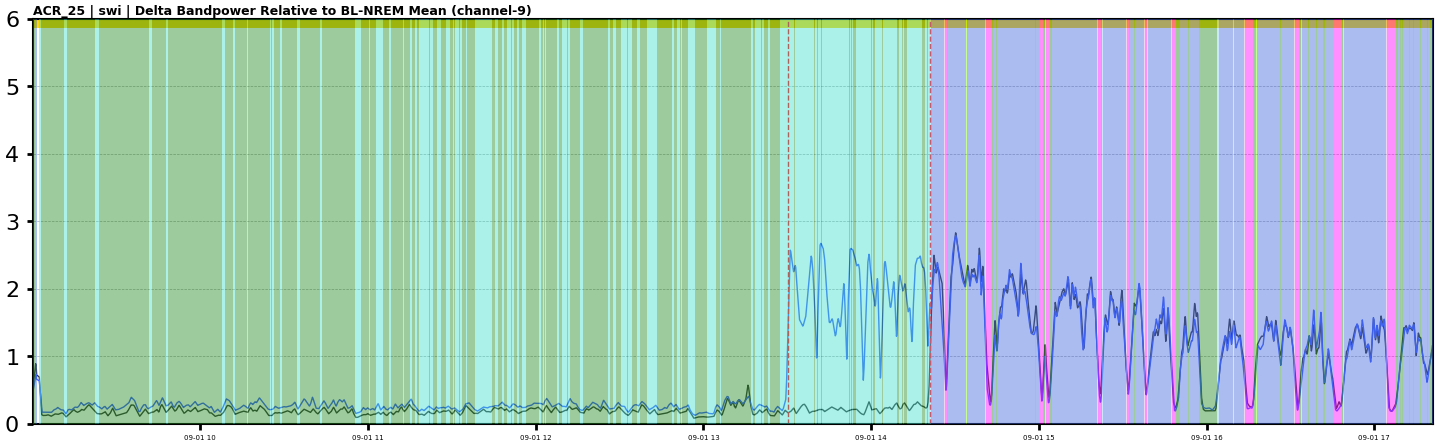

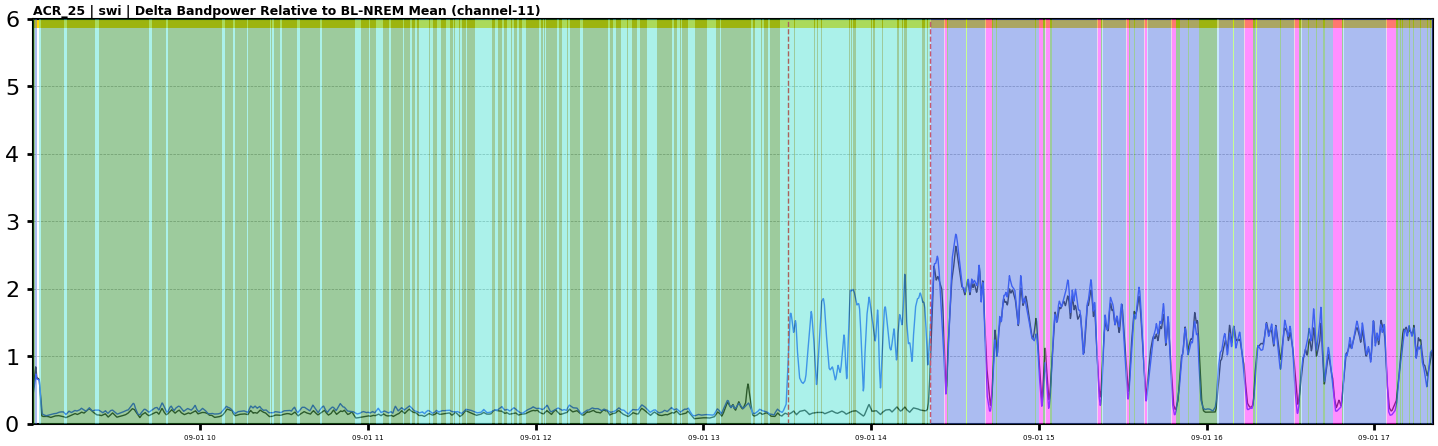

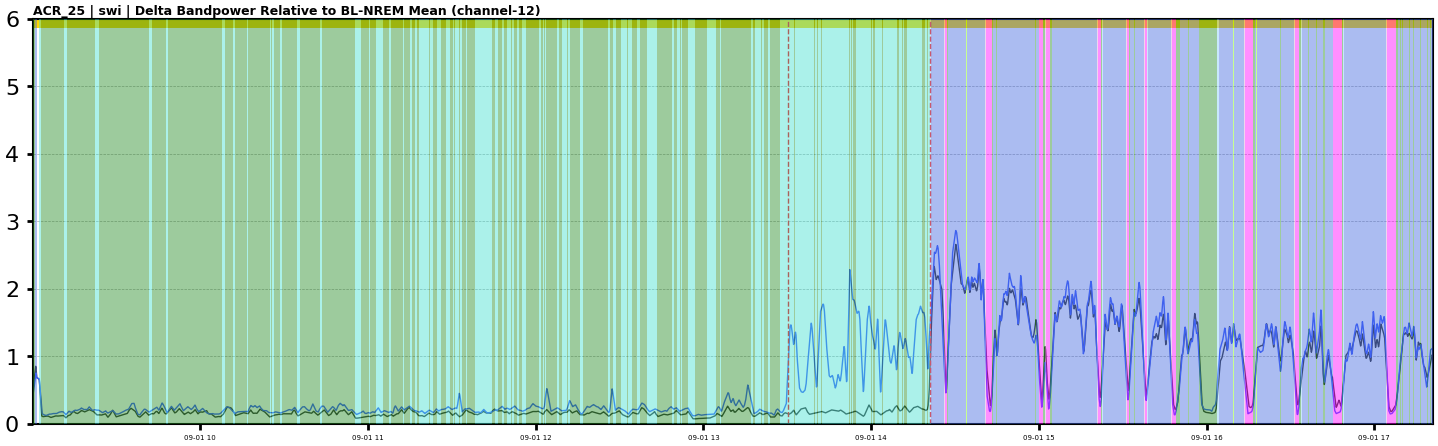

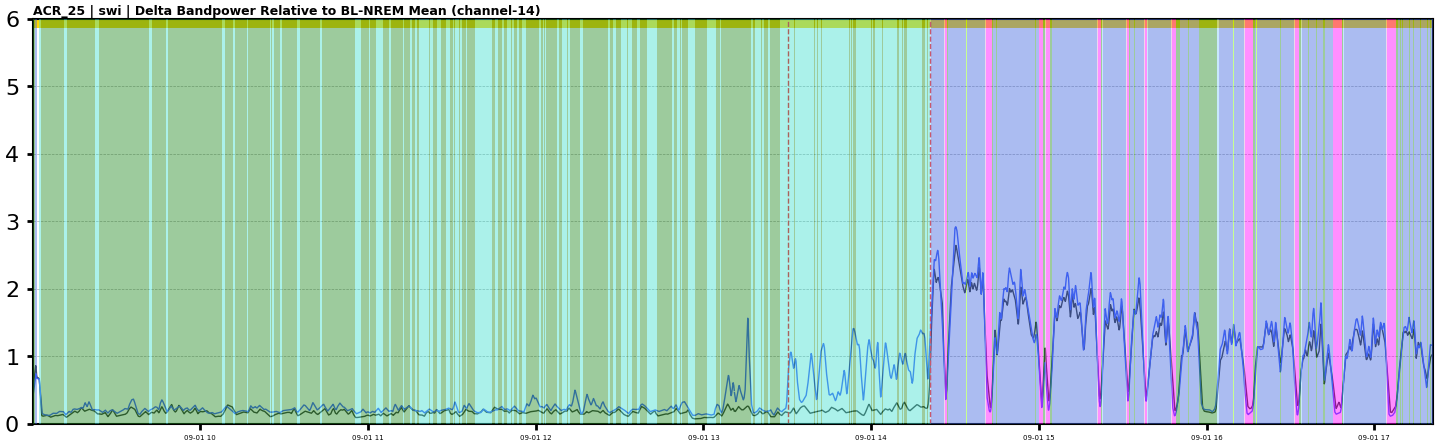

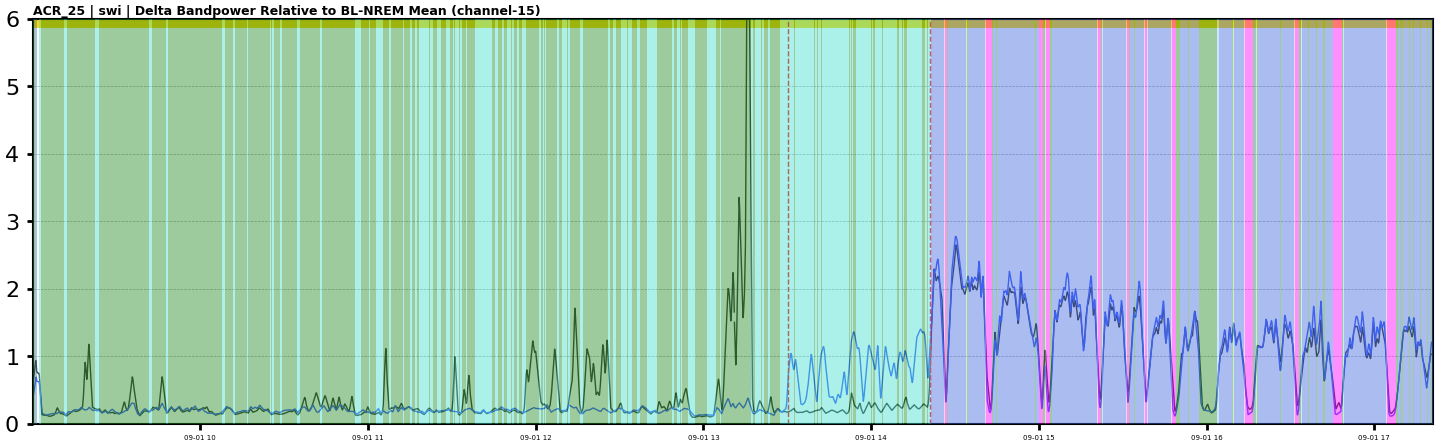

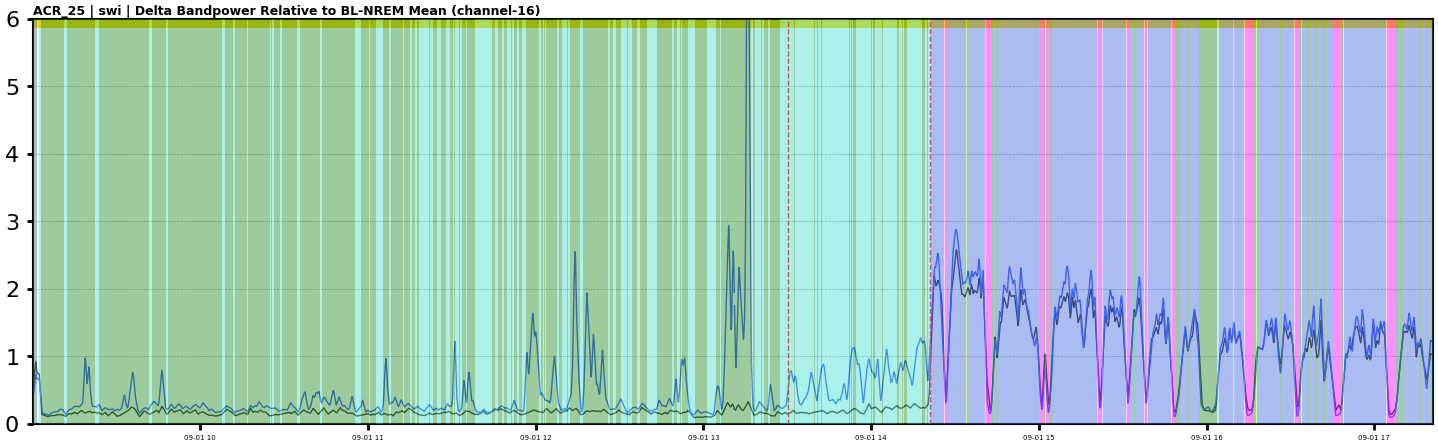

In [24]:
for channel in np.arange(1, 17):
    if channel not in bp_rel.channel.values:
        continue
    f, ax = plt.subplots(1, 1, figsize=(35, 10), sharex=True)
    ax.set_ylim(0, 6);

    # plot delta and gamma power
    kde.plot.main.bp_plot(bp_rel.prb('NNXr').delta.ch(channel).smooth(sigma=24).ts(t1, t2), ax, h)
    kde.plot.main.bp_plot(bp_rel.prb('NNXo').delta.ch(channel).smooth(sigma=24).ts(t1, t2), ax, h)
    ax.set_xlim(t1, t2)
    # plot relative firing rate
    #ax[2] = acr.pl_units.plot_fr_by_probe(df_rel.ts(t1, t2), h, ax=ax[2], color=True)

    #add the stimulation start and end times
    ax.axvline(stim_start, color='red', linestyle='--')
    ax.axvline(stim_end, color='red', linestyle='--')


    kde.plot.main._title(ax, subject, exp, f'Delta Bandpower Relative to BL-NREM Mean (channel-{channel})');
    #f.savefig(f'./plots/{subject}_{exp}_delta_bp_channel_{channel}.png', dpi=300, bbox_inches='tight')